# Проверка гипотезы в сервисе чтения и прослушивания книг Яндекс.Книги
Дата 13.06.2025

## Цели и задачи проекта

**Описание задания:** Сервис Яндекс.Книги позволяет читать и прослушивать аудиоконтент за ежемесячную подписку. 
Команда сервиса Яндекс Книги изучила данные, полученные при анализе LTV, и предположила, что  пользователи, которые приносят больший LTV, являются более лояльными, т.е. проводят в среднем больше времени за чтением и прослушиванием книг в приложении. Предлагается сравнить пользователей из Санкт-Петербурга и Москвы. 

**Гипотеза**: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы.  Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.</font>

Нулевая гипотеза $H_0: \mu_{\text{СПб}} \leq \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге не больше, чем в Москве.

Альтернативная гипотеза $H_1: \mu_{\text{СПб}} > \mu_{\text{Москва}}$ <br> Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

## Описание данных

Работаем с файлом yandex_knigi_data.csv.
Путь к файлу: 'datasets/yandex_knigi_data.csv.'

Поля таблицы: 
- `city` — город пользователя;

- `puid` — идентификатор пользователя;

- `hours` — количество часов пользователя в приложении.</font>

## План работы
<font color='#777778'>

* Загрузка библиотек

* Загрузка данных
    
* Первичный анализ и предобработка данных
    
* Выбор целевой метрики

* Разделение на тестовые группы
    
* Расчет параметров А/В теста
    
* Статистический тест
    
* Анализ результатов теста

</font>

## Загрузка библиотек¶

In [1]:
#загружаем нужные для работы библиотеки и функции
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro, norm, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from datetime import date, timedelta

In [4]:
# Библиотека для диаграмм Венна
from matplotlib_venn import venn2

## Загрузка данных и знакомство с ними

In [5]:
#загружаем данные
try:
    df_books = pd.read_csv('datasets/yandex_knigi_data.csv')
    display('Файл yandex_knigi_data.csv загружен в датасет df_books')
except:
    display('Ошибка загрузки файла yandex_knigi_data.csv')

'Файл yandex_knigi_data.csv загружен в датасет df_books'

## Первичный анализ и предобработка данных

In [6]:
#смотрим на данные
df_books.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [7]:
# анализируем структуру датафрейма
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [8]:
# проверим, что в данных присутствуют пользователи только нужных нам городов
display(df_books['city'].unique())

array(['Москва', 'Санкт-Петербург'], dtype=object)

Датафрейм **df_books** содержит 4 столбца и 8784 строки. Данные соответствуют заявленным и содержат информацию о часах, проведенных в приложении пользователями Москвы и Санкт-Петербурга. Пропуски в данных - отсутствуют. 

## Выбор целевой метрики

Базовая метрика - количество часов в столбце 'hours'.

In [9]:
# получаем описательную статистику столбца с количеством часов
df_books['hours'].describe()

count    8784.000000
mean       11.087670
std        37.701350
min         0.000018
25%         0.066246
50%         0.942344
75%         6.065151
max       978.764775
Name: hours, dtype: float64

Минимальное значение - 0,000018 ч (>0), максимальное - 978,76 ч. Среднее (= 11,08) и медиана (=0,94) по столбцу 'hours' значительно различаются, что говорит о наличии выбросов. Также о вариативности данных говорит большое стандартное отклонение = 37,7 ч.

In [10]:
#проверим на полные дубликаты 
display(f'Полных дубликатов {df_books.duplicated().sum()} строк')

'Полных дубликатов 0 строк'

In [11]:
#проверим на дубликаты по ID пользователя
display(f'Дубликатов по ID пользователя {df_books.duplicated(subset = ["puid"]).sum()} строк')

'Дубликатов по ID пользователя 244 строк'

Возможно, эти дубликаты относятся к пользователям, которые мигрируют между Москвой и Санкт-Петербургом. Разобьем на группы и посмотрим на пересечения.

In [12]:
set_users_A = set(df_books['puid'].loc[df_books['city'] == 'Москва'])
set_users_B = set(df_books['puid'].loc[df_books['city'] == 'Санкт-Петербург'])

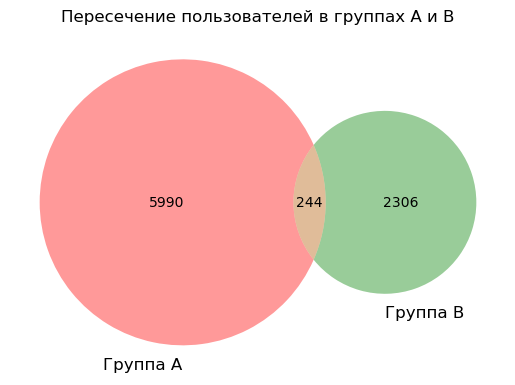

In [13]:
# Строим диаграмму Венна
v = venn2(subsets=[set_users_A, set_users_B], \
          set_labels=('Группа А', 'Группа B'))
plt.title("Пересечение пользователей в группах А и В")
plt.show()   

244 человека в пересечении групп А и В. Для корректного тестирования удалим таких пользователей из анализа. 

In [14]:
set_users_A_nodub = set_users_A.difference(set_users_B)
set_users_B_nodub = set_users_B.difference(set_users_A)

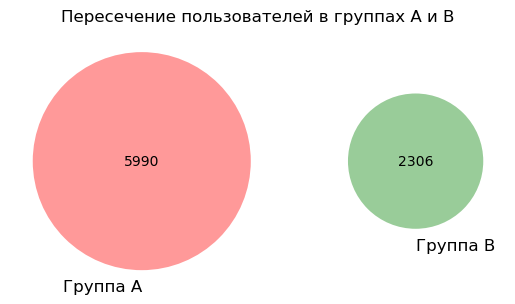

In [15]:
# Визуально проверяем корректность удаления пересечения 
v = venn2(subsets=[set_users_A_nodub, set_users_B_nodub], \
          set_labels=('Группа А', 'Группа B'))
plt.title("Пересечение пользователей в группах А и В")
plt.show()   

## Разделение на тестовые группы

In [16]:
#разбиваем датафрейм на группы в соответствии с получившимися множествами ID пользователей (без пересечений между группами)
group_A = df_books.loc[df_books['puid'].isin(set_users_A_nodub)]
group_B = df_books.loc[df_books['puid'].isin(set_users_B_nodub)]

In [17]:
display(f'Дубликатов по ID пользователя в группе А {group_A.duplicated(subset = ["puid"]).sum()} строк')
display(f'Дубликатов по ID пользователя в группе В {group_B.duplicated(subset = ["puid"]).sum()} строк')

'Дубликатов по ID пользователя в группе А 0 строк'

'Дубликатов по ID пользователя в группе В 0 строк'

In [18]:
#считаем количество пользователей в группе А
count_users_A = group_A['puid'].nunique()
display(f'Количество пользователей в группе А: {count_users_A}')

'Количество пользователей в группе А: 5990'

In [19]:
#считаем количество пользователей в группе B
count_users_B = group_B['puid'].nunique()
display(f'Количество пользователей в группе B: {count_users_B}')

'Количество пользователей в группе B: 2306'

In [20]:
#Считаем процентную разницу между группами
P = 100*abs((count_users_A - count_users_B)/count_users_A)
display(f'Процентная разница в количестве пользователей в группах A и B: {P}')

'Процентная разница в количестве пользователей в группах A и B: 61.50250417362271'

Группы распределены неравномерно, между группами наблюдается большая процентная разница, что может повлиять на раезультаты эксперимента. Визуализируем разницу.

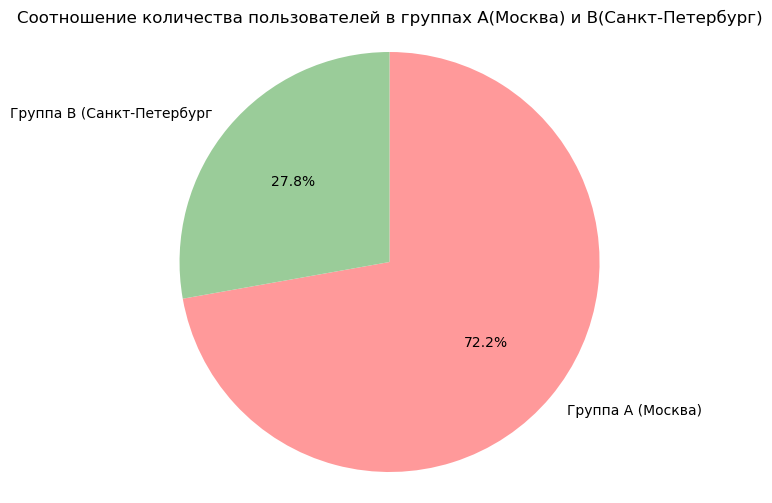

In [21]:
#строим круговую диаграмму
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie([count_users_A,count_users_B], labels=['Группа А (Москва)','Группа В (Санкт-Петербург'], autopct='%1.1f%%', startangle=90,\
        colors=['#ff999a','#9acc99'], counterclock=False)
plt.axis('equal')
ax.set_title('Соотношение количества пользователей в группах А(Москва) и В(Санкт-Петербург)')
plt.show()

Сравним описательные статистики в группах.

In [22]:
group_A['hours'].describe()

count    5990.000000
mean       10.848192
std        36.925622
min         0.000022
25%         0.057042
50%         0.888232
75%         5.933439
max       857.209373
Name: hours, dtype: float64

In [23]:
group_B['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

Значения: среднее, стандартное отклонение и т.д. одного порядка и говорят о том, что метрика сопоставима между группами. Визуализируем распределение данных в группах.

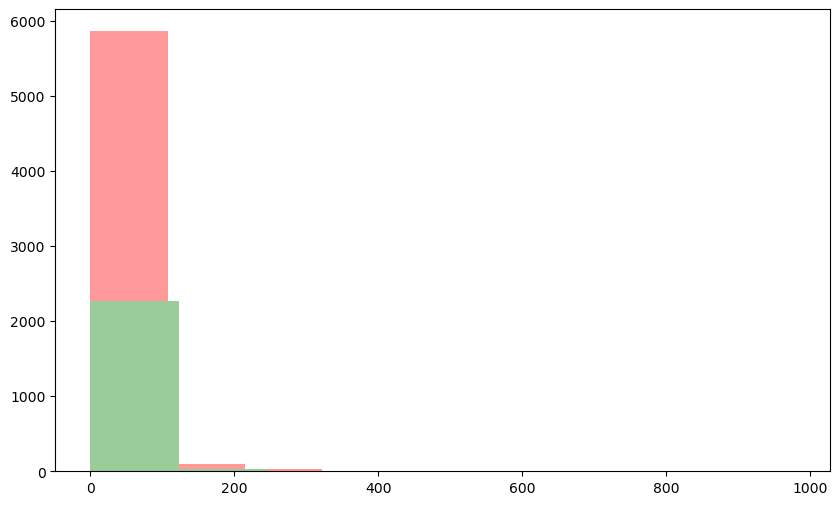

In [24]:
#гистограмма
plt.figure(figsize=(10,6))
plt.hist(group_A['hours'],bins=8, color='#ff999a')
plt.hist(group_B['hours'],bins=8, color='#9acc99')
plt.show()

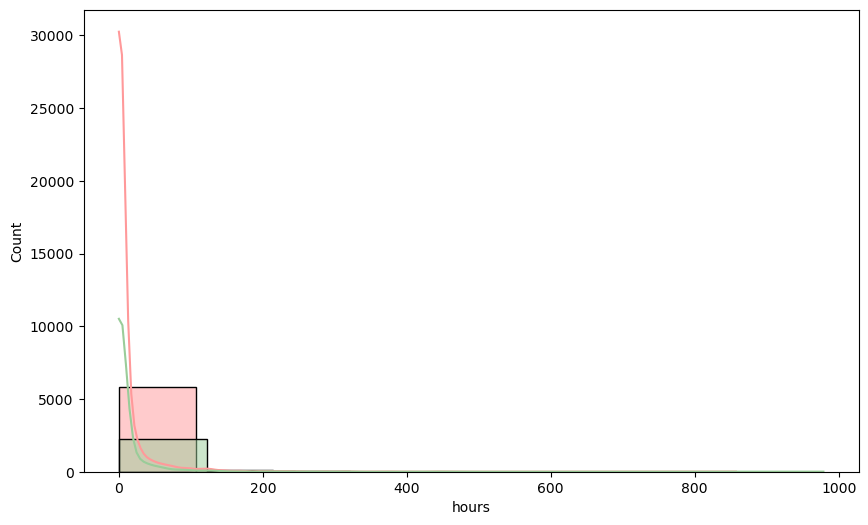

In [25]:
#гистограмма с плотностью вероятности
plt.figure(figsize=(10,6))
sns.histplot(group_A['hours'], kde=True, bins=8, color='#ff999a')
sns.histplot(group_B['hours'], kde=True, bins=8, color='#9acc99')
plt.show()

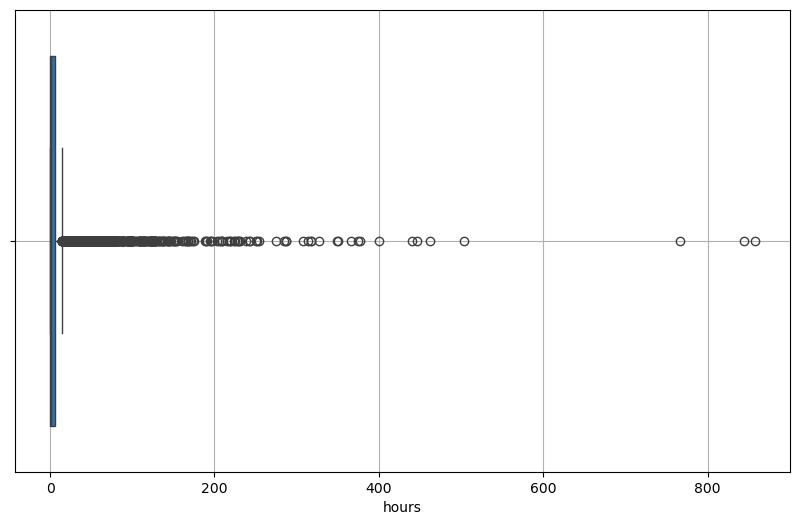

In [26]:
#диаграмма размаха - группа А
plt.figure(figsize=(10,6))
sns.boxplot(data=group_A, x='hours')
plt.grid()
plt.show()

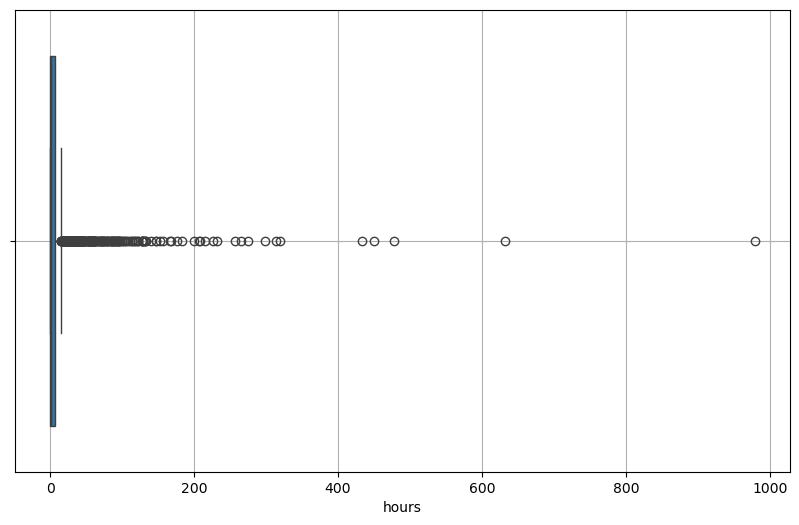

In [27]:
#диаграмма размаха - группа В
plt.figure(figsize=(10,6))
sns.boxplot(data=group_B, x='hours')
plt.grid()
plt.show()

На гистограммах и диаграммах видно, что распределение в группах - не нормальное. Дополнительно проверим распределение данных в группе В на нормальность тестом Шапиро‑Уилка. К группе А этот тест не применяем т.к. он некорректно работает при размере выборке >5000. Но распределение в группах похожее, и результат можем считать для обеих групп.

In [28]:
# Применяем тест Шапиро-Уилка - группа B
stat, pvalue = shapiro(group_B['hours'])

alpha = 0.05
if pvalue > alpha:
    print(f'p={pvalue} - Данные в группе В распределены нормально')
else:
    print(f'p={pvalue} - Данные в группе В распределены НЕ нормально')

p=8.714980058671263e-70 - Данные в группе В распределены НЕ нормально


## Расчет параметров А/В теста

Целевая метрика - количественная - количество часов, проведенное в приложении.

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Итак, для выбора статистического теста учитываем, что:
1. Размеры выборки в группах А и В значительно отличаются.
2. Распределение данных в группах - не нормальные.
3. Присутствуют выбросы справа в обеих группах.

t-тест Стъюдента не подходит. 
Выбираем тест **Манна-Уитни**, т.к. он
1. Не требует нормального распределения.
2. Не чувствителен к выбросам.

Выбираем уровень значимости alpha = 0.05

## Статистический тест. Проверка гипотезы в Python

In [29]:
#применяем тест Манна-Уитни

alpha = 0.05 #уровень значимости

stat_mw, pvalue_mw = mannwhitneyu(group_A['hours'], group_B['hours'], alternative = 'less')

if pvalue_mw >= alpha:
   display(f'Значение p-value {pvalue_mw} >= {alpha}. Принимаем нулевую гипотезу - Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')
else:
    display(f'Значение p-value {pvalue_mw} < {alpha}. Принимаем альтернатитвную гипотезу. Средняя активность пользователей в Санкт-Петербурге больше.')

'Значение p-value 0.4532273739367588 >= 0.05. Принимаем нулевую гипотезу - Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается'

Дополнительно можно проверить гипотезу, уменьшив размер группы А, чтобы выборки были сопоставимы по размерам, выбрав записи случайным образом.

In [30]:
# Выбираем 2306 случайных элементов из группы А (2306 - размер группы В)
random_group_A = group_A.sample(2306)
random_group_A.shape[0]

2306

In [31]:
#снова применим тест Манна-Уитни

alpha = 0.05 #уровень значимости

stat_mw, pvalue_mw = mannwhitneyu(random_group_A['hours'], group_B['hours'], alternative = 'less')

if pvalue_mw >= alpha:
   display(f'Значение p-value {pvalue_mw} >= {alpha}. Принимаем нулевую гипотезу - Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается')
else:
    display(f'Значение p-value {pvalue_mw} < {alpha}. Принимаем альтернатитвную гипотезу. Средняя активность пользователей в Санкт-Петербурге больше.')

'Значение p-value 0.4606574296425239 >= 0.05. Принимаем нулевую гипотезу - Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается'

## Вывод по результатам теста. Аналитическая записка

1. Суть проводимого А/В теста: Подтвердить или опровергнуть гипотезу, что в сервисе Яндекс.Книги пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы. 

    Ключевая метрика - среднее время активности пользователей. Длительность эксперимента - неизвестно. Количество пользователей: в группе А - 5990(72,2%), в группе В - 2306(27,8%) человек.


2. Для проверки гипотезы выбран статистический тест **Манна-Уитни**, т.к. размеры выборки в группах А и В значительно отличаются, распределение данных в группах - не нормальные, в обеих группах присутствуют выбросы. Уровень значимости выбран = 5%.



3. В результате теста значение p-value для оценки статистической значимости выявленного эффекта составляет 0.4532273739367588 при полном размере выборке А и 0.33688997270630766 при ограничении случайным образом группы А до размеров группы В, что значительно больше уровня значимости = 0.05. 


4. Интрепретация теста: принимаем нулевую гипотезу - средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.


5. Возможные причины: 

 а) неизвестно когда, в какое время и сколько времени собирались данные для эксперимента. 
 
 б) были удалены данные по пользователям, мигрирующим между городами и  входящими в обе группы А и В. Эти пользователи, вполне могли быть жителями Санкт-Петербурга, данные по которым мы отбросили, что повлияло на метрику по Санкт-Петербургу.